In [1]:
import time
import pandas as pd
import dask.dataframe as dd
import numpy as np
import plotly.graph_objects as go
import plotly.offline as po
import plotly.express as px
import os,sys
import json
from array import array

from collections import defaultdict
from scipy.signal import find_peaks
# Insert the path of modules folder 
# sys.path.insert(0, 'C:/Users/Jason/thesis_project')
sys.path.append("../")

from support import *
from features.feature_ts import genX
from experiment.algorithms.cluster_prep import *

C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\os.py
c:\Users\Jason\thesis_project


In [2]:
X = genX([1994,2014], drop_0 = True)

Xbin = xBins(X, 'amd')

dropping all zero rows


### Looking at users from a specific bin 600-1200

In [3]:
list_len = []
list_ids = []

for ids in Xbin['2500-4000']:
    list_ids.append(ids)
    list_len.append(len(X.loc[ids,:]))

# Find the household that logged the most data
ix = list_len.index(max(list_len))

# Store the households ID
house_id = list_ids[ix]

# Create a dataframe with all of that households data
A = X.loc[house_id,:]
H = A.copy()

In [4]:
H = A.copy()
# H = A.reset_index()
# H.drop(['date'], axis = 1, inplace = True)

In [5]:
def find_peaksMA(X):

    df = X.copy()
    arrayX  = X.to_numpy().copy()
    arrayY = X.to_numpy().copy()

    listYM  = list(map(lambda x : x[:12],arrayY))
    listYA  = list(map(lambda x : x[12:],arrayY))

    arrayYM = np.array(listYM)
    arrayYA = np.array(listYA)

    # arrayYM.sort()
    # arrayYA.sort()

    dict_M = defaultdict(list)
    dict_A = defaultdict(list)

    df.reset_index(inplace = True)

    for i in range(0,len(arrayX)):
        indices_M = np.where(arrayYM[i] == np.amax(arrayYM[i]))
        indices_A = np.where(arrayYA[i] == np.amax(arrayYA[i]))

        dict_M[i].append(indices_M[0][0]) 
        dict_A[i].append(indices_A[0][0])

    ToP_M_df = pd.DataFrame.from_dict(dict_M)
    ToP_A_df = pd.DataFrame.from_dict(dict_A)

    top_M_dict = ToP_M_df.T
    top_A_dict = ToP_A_df.T + 12

    dict_M.clear() 
    dict_A.clear()


    X1 = df.merge(top_M_dict, left_index = True, right_index = True).merge(top_A_dict,left_index = True, right_index = True)

    return X1

In [6]:
# def plotPeaks(X, bin)
from plotly.subplots import make_subplots

def plotToPs(A, bin):
    
    temp = find_peaksMA(A)

    ToPs = calculateToPs(temp)

    indices = temp['0_x']

    # fig = make_subplots(rows=2, cols=1, subplot_titles=("Amplitude vs Time of Peak", "Histogram of ToPs"))

    fig = go.Figure()

    # def add_new_trace(index):
    #     fig.append_trace(go.Scatter(
    #     x=[int(i) for i in indices[index]],
    #     y=temp.loc[index,indices[index]].values,
    #     mode='markers',
    #     marker=dict(
    #         size=8,
    #         color='red',
    #         symbol='circle'
    #     ),
    #     name='Detected Peaks',
    #     showlegend = False
    #     ),row =1, col =1)  

    # for i in temp.index:
    #     add_new_trace(i)

    # fig.update_yaxes(title_text="Amplitude", row = 1, col = 1)

    # fig.update_xaxes(title_text = "Time of Peak")

    # fig.update_layout(title="Profiles for bin " + str(bin),
    #     xaxis = dict(
    #         tickmode = 'linear',
    #         tick0 = 0,
    #         dtick = 1
    #     )
    # )

    #Plot Histogram of "total_bill" with rugplot parameters
    fig.append_trace(px.histogram(x=ToPs),row = 2, col =1)

    fig.update_yaxes(title_text="Count", row = 2, col = 1)

    # po.plot(fig, auto_open=False, filename=data_dir+'/plots/ToP_Amplitude_'+str(bin)+'.html')
    fig.show()

In [7]:
def calculateToPs(X1):
    
    X1['ToP'] = X1[['0_x', '0_y']].values.tolist()
    ToP = X1.groupby(['date'])['ToP'].apply(pd.Series.tolist)
    temp = ToP.map(lambda x : [item for sublist in x for item in sublist])

    ToPs = temp.apply(pd.Series).stack().reset_index(drop = True)

    print(ToPs)

    return ToPs

In [8]:
temp = find_peaksMA(H)

ToPs = calculateToPs(temp)

temp.drop(['date'], axis = 1, inplace = True)

indices = temp['ToP']

fig = make_subplots(rows=2, cols=1, subplot_titles=("Amplitude vs Time of Peak", "Histogram of ToPs"))

# fig = go.Figure()

def add_new_trace(index):
    fig.append_trace(go.Scatter(
    x=[int(i) for i in indices[index]],
    y=temp.iloc[index,indices[index]].values,
    mode='markers',
    marker=dict(
        size=8,
        color='red',
        symbol='circle'
    ),
    name='Detected Peaks',
    showlegend = False
    ),row =1, col =1)  

for i in temp.index:
    add_new_trace(i)

fig.update_yaxes(title_text="Amplitude", row = 1, col = 1)

fig.update_xaxes(title_text = "Time of Peak")

fig.update_layout(title="Profiles for bin " + str(bin),
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    )
)

ToPs_df = ToPs.to_list()

#Plot Histogram of "total_bill" with rugplot parameters
fig.append_trace(px.histogram(x = ToPs_df),row = 2, col =1)

fig.update_yaxes(title_text="Count", row = 2, col = 1)

# po.plot(fig, auto_open=False, filename=data_dir+'/plots/ToP_Amplitude_'+str(bin)+'.html')
fig.show()

0      11
1      19
2       7
3      18
4       7
       ..
207    15
208    10
209    17
210     6
211    12
Length: 212, dtype: int64


ValueError: 
    Invalid element(s) received for the 'data' property of 
        Invalid elements include: [Figure({
    'data': [{'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'x=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': '',
              'offsetgroup': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'histogram',
              'x': array([11, 19,  7, ..., 17,  6, 12], dtype=int64),
              'xaxis': 'x',
              'yaxis': 'y'}],
    'layout': {'barmode': 'relative',
               'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'x'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'count'}}}
})]

    The 'data' property is a tuple of trace instances
    that may be specified as:
      - A list or tuple of trace instances
        (e.g. [Scatter(...), Bar(...)])
      - A single trace instance
        (e.g. Scatter(...), Bar(...), etc.)
      - A list or tuple of dicts of string/value properties where:
        - The 'type' property specifies the trace type
            One of: ['bar', 'barpolar', 'box', 'candlestick',
                     'carpet', 'choropleth', 'choroplethmapbox',
                     'cone', 'contour', 'contourcarpet',
                     'densitymapbox', 'funnel', 'funnelarea',
                     'heatmap', 'heatmapgl', 'histogram',
                     'histogram2d', 'histogram2dcontour', 'icicle',
                     'image', 'indicator', 'isosurface', 'mesh3d',
                     'ohlc', 'parcats', 'parcoords', 'pie',
                     'pointcloud', 'sankey', 'scatter',
                     'scatter3d', 'scattercarpet', 'scattergeo',
                     'scattergl', 'scattermapbox', 'scatterpolar',
                     'scatterpolargl', 'scattersmith',
                     'scatterternary', 'splom', 'streamtube',
                     'sunburst', 'surface', 'table', 'treemap',
                     'violin', 'volume', 'waterfall']

        - All remaining properties are passed to the constructor of
          the specified trace type

        (e.g. [{'type': 'scatter', ...}, {'type': 'bar, ...}])

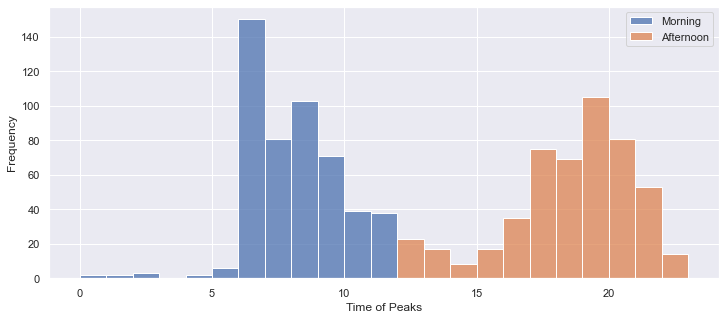

In [ ]:
import seaborn as sns


temp1 = temp[['0_x','0_y']].copy()
temp1.rename(columns = {'0_x':'Morning', '0_y':'Afternoon'}, inplace = True)
ax = sns.histplot(data=temp1, linewidth=1, color='lightsteelblue', binwidth=1)
# ax = sns.distplot(temp1)
ax.set(ylabel='Frequency', xlabel='Time of Peaks')
sns.set(rc={"figure.figsize":(12, 5)}) #width=3, #height=4

### Find the most frequent time of peak

In [9]:
def most_frequent(List):
    return max(set(List), key = List.count)

In [10]:
morning_freguent_peak = most_frequent(temp1['Morning'].to_list())
afternoon_freguent_peak = most_frequent(temp1['Afternoon'].to_list())

NameError: name 'temp1' is not defined

# Detremine where the daily data increases and decreases after and before the peaks

### Find the average profile of a user

In [11]:
import random

list_len = []
list_ids = []

for ids in Xbin['600-1200']:
    list_ids.append(ids)
    list_len.append(len(X.loc[ids,:]))


# def selectRandomUser():
#     # Find the household that logged the most data
#     ix = list_len.index(random.choice(list_len))

#     # Store the households ID
#     house_id = list_ids[ix]

#     print(house_id)

#     # Create a dataframe with all of that households data
#     A = X.loc[house_id,:]
#     H = A.copy()

#     return H

In [12]:
def selectRandomUser(Household):
    # # Find the household that logged the most data
    # ix = list_len.index(5283)

    # # Store the households ID
    # house_id = list_ids[ix]

    # print(house_id)
    house_id = Household
    # Create a dataframe with all of that households data
    A = X.loc[house_id,:]
    H = A.copy()

    return H

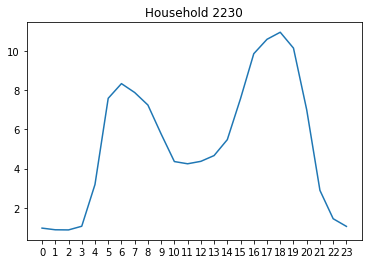

<Figure size 432x288 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt

id = [2230]#,1002790,483,3063,5351,12020322,5283,5293,168,7118,156,5239,29,1418,1005536]

for i in id:
    H = selectRandomUser(i)

    H1 = find_peaksMA(H)
    H1_d = H1.describe()
    H1_d.drop(['0_x','0_y'], axis = 1, inplace = True)
    H1_d1 = find_peaksMA(H1_d)
    H1_d1 = H1_d1.drop([0, 2,3,7])
    fig = plt.plot(H1_d1.iloc[0,1:25])
    plt.title("Household "+str(i))
    # plt.savefig(str(i)+'.png')
    plt.show()
    plt.clf()


### Superimpose gaussian on plot

In [14]:
# normal_curve.py

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
# if using a Jupyter notebook, inlcude:
%matplotlib inline

#### Function to determine households mean, peak times

In [15]:
def find_peaksMA(X):    
    # Create a copy of households mean electricity usage
    df = X.copy()

    arrayX = X.to_numpy().copy()

    listYM  = list(map(lambda x : x[:12],arrayX))
    listYA  = list(map(lambda x : x[12:],arrayX))

    arrayYM = np.array(listYM)
    arrayYA = np.array(listYA)

    dict_M = defaultdict(list)
    dict_A = defaultdict(list)

    # Determine the time when the peaks occur
    indices_M = np.where(arrayYM[0] == np.amax(arrayYM[0]))
    indices_A = np.where(arrayYA[0] == np.amax(arrayYA[0]))

    dict_M[i].append(indices_M[0][0]) 
    dict_A[i].append(indices_A[0][0])

    ToP_M_df = pd.DataFrame.from_dict(dict_M)
    ToP_A_df = pd.DataFrame.from_dict(dict_A)

    top_M_dict = ToP_M_df.T
    top_A_dict = ToP_A_df.T + 12 # Adjust for time

    # Reset index to insure that the three dataframes below merge properly
    top_M_dict = top_M_dict.reset_index()
    top_M_dict.drop(['index'], axis = 1, inplace = True)

    top_A_dict = top_A_dict.reset_index()
    top_A_dict.drop(['index'], axis = 1, inplace = True)
    
    df.reset_index(inplace = True)
    df.drop(['index'], axis = 1, inplace = True)

    dict_M.clear() 
    dict_A.clear()


    X1 = df.merge(top_M_dict, left_index = True, right_index = True).merge(top_A_dict,left_index = True, right_index = True)

    return X1

In [16]:

def describe_household():
       # Household ids
       id = [2230]#,1002790,483,3063,5351,12020322,5283,5293,168,7118,156,5239,29,1418,1005536]

       for i in id:
              H = selectRandomUser(i)

              # H1 = find_peaksMA(H)
              H1_d = H.describe()

              H1_d = H1_d.drop(['count','std','min','max', '25%','50%','75%'])
              
              H1_d1 = find_peaksMA(H1_d)
              
       return H1_d1

#### Code to create Gaussian

In [17]:
#Define the Gaussian function
def gauss(x, H, A, mu, sigma):
    return H + A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

#### Code to plot the Gaussian fit

In [18]:
import matplotlib.pyplot as plt


def plotGaussFit(y2):
    # Household ids
    # id = [2230]#,1002790,483,3063,5351,12020322,5283,5293,168,7118,156,5239,29,1418,1005536]

    x_all = np.arange(0, 24, 0.001) # entire range of x, both in and out of spec

    # build the plot
    fig, ax = plt.subplots(figsize=(12,6))
    plt.style.use('fivethirtyeight')  

    # Plot the households loadprofile
    fig = plt.plot(describe_household().iloc[0,0:24])
    plt.title("Household "+str(i))

    # Plot Gaussian fit
    ax.plot(x_all,y2)

    # Set the labels and axis limits
    ax.set_xlim([0,24])
    ax.set_xlabel('Time of day')
    ax.set_ylabel("Amplitude")
    ax.set_title('Gaussian Curve Fit')

    # # Save the figure
    # plt.savefig('normal_curve.png', dpi=72, bbox_inches='tight')
    plt.show()

#### Extract variables

In [19]:
df = describe_household()

# Determine the y-offset i.e. minimum value in day
H_offset = df.min(axis = 1).values[0] 

# Determine the amplitude of gaussian
A1 = df[str(df['0_x'].values[0])].values[0] - H_offset # Adjust for offset
A2 = df[str(df['0_y'].values[0])].values[0] - H_offset

# Determine the mean of the gaussian
mu1 = df['0_x'].values[0]
mu2 = df['0_y'].values[0]

#### Perform the standard deviation guess

In [107]:
x_all = np.arange(0, 24, 0.001)
def initialSigma():
    x_all = np.arange(0, 24)

    i = 0
    Xpeak = df[str(df['0_x'].values[0])].values[0]
    for c in df:
        xi = df[str(df['0_x'].values[0]-int(c))].values[0]
        temp = Xpeak - xi
        
        if temp >= 0:
            Xpeak = xi
        else:
            i = df['0_x'].values[0]-int(c)+1 # i returns the index of the lower boundary of range
            break

    range = 2*(df['0_x'].values[0] - i)

    sigma = range/6

    return sigma

y2 = gauss(x_all, H_offset,A1,mu1,initialSigma())

#### Add code to determine range of downward slope gaussian i.e. gaussian 2, 4

In [358]:
def initialSigma1(increment = 0):
    

    # Conditional if statement to check that 
    p1 = 4 + increment

    # p2 = 4 + increment2

    i1 = 0
    # i2 = 0
    Xpeak1 = df[str(df['0_x'].values[0])].values[0]
    # Xpeak2 = df[str(df['0_y'].values[0])].values[0]
    for c in df:
        x1 = df[str(df['0_x'].values[0] - int(c))].values[0]
        temp1 = Xpeak1 - x1
        # print("temp1 = Xpeak1 - x1 = {} - {} = {}".format(Xpeak1,x1,temp1))

        if temp1 >= 0.0:
            Xpeak1 = x1
        else:
            i1 = df['0_x'].values[0]-int(c)+1 # i returns the index of the lower boundary of range
            break

    # for c in df:
    #     x2 = df[str(df['0_y'].values[0]-int(c))].values[0]
    #     temp2 = Xpeak2 - x2
        
    #     if temp2 >= 0.0:
    #         Xpeak2 = x2
    #     else:
    #         i2 = df['0_y'].values[0]-int(c)+1 # i returns the index of the lower boundary of range
    #         break

    range1 = 2*(np.sqrt((df['0_x'].values[0] - i1)**2))
    # range2 = 2*(np.sqrt((df['0_y'].values[0] - i2)**2))

    sigma1 = range1/p1
    # sigma2 = range2/p2

    return sigma1, i1


# sigma1, sigma2, i1, i2 = initialSigma1()
# y2 = gauss(x_all, H_offset,A1,mu1,initialSigma2())

In [359]:
def initialSigma3(increment = 0):
    

    # Conditional if statement to check that 
    # p1 = 4 + increment

    p2 = 4 + increment

    # i1 = 0
    i2 = 0
    # Xpeak1 = df[str(df['0_x'].values[0])].values[0]
    Xpeak2 = df[str(df['0_y'].values[0])].values[0]
    # for c in df:
    #     x1 = df[str(df['0_x'].values[0] - int(c))].values[0]
    #     temp1 = Xpeak1 - x1
    #     # print("temp1 = Xpeak1 - x1 = {} - {} = {}".format(Xpeak1,x1,temp1))

    #     if temp1 >= 0.0:
    #         Xpeak1 = x1
    #     else:
    #         i1 = df['0_x'].values[0]-int(c)+1 # i returns the index of the lower boundary of range
    #         break

    for c in df:
        x2 = df[str(df['0_y'].values[0]-int(c))].values[0]
        temp2 = Xpeak2 - x2
        
        if temp2 >= 0.0:
            Xpeak2 = x2
        else:
            i2 = df['0_y'].values[0]-int(c)+1 # i returns the index of the lower boundary of range
            break

    # range1 = 2*(np.sqrt((df['0_x'].values[0] - i1)**2))
    range2 = 2*(np.sqrt((df['0_y'].values[0] - i2)**2))

    # sigma1 = range1/p1
    sigma2 = range2/p2

    return sigma2, i2


# sigma1, sigma2, i1, i2 = initialSigma1()

In [360]:
x_all = np.arange(0, 24)

def initialSigma2(increment = 0):
    x_all = np.arange(0, 24)

    # Conditional if statement to check that 
    p1 = 4 + increment

    # p2 = 4 + increment2

    i1 = 0
    # i2 = 0
    Xpeak1 = df[str(df['0_x'].values[0])].values[0]# Get the value at the peak
    # Xpeak2 = df[str(df['0_y'].values[0])].values[0]# Get the value at the peak
    
    for c in df:
        x1 = df[str(df['0_x'].values[0]+int(c))].values[0]
        temp1 = Xpeak1 - x1
        # print("temp1 = Xpeak1 - x1 = {} - {} = {}".format(Xpeak1,x1,temp1))
        if temp1 >= 0:
            Xpeak1 = x1
        else:
            i1 = df['0_x'].values[0]+int(c)-1 # i returns the index of the lower boundary of range
            break

    # for c in df:
    #     # print(c)
    #     # c = int(c)-1
    #     try:
    #         x2 = df[str(df['0_y'].values[0]+int(c))].values[0] # Get the one after the peak
    #         temp2 = Xpeak2 - x2
    #         # print("temp2 = Xpeak2 - x2 = {} - {} = {}".format(Xpeak2,x2,temp2))
            
    #         if temp2 >= 0:
    #             Xpeak2 = x2
    #         else:
    #             i2 = df['0_y'].values[0]+int(c)-1 # i returns the index of the lower boundary of range
    #             break
            
    #     except KeyError:
    #         i2 = df['0_y'].values[0]+int(c)-1
    #         break


    range1 = 2*(np.sqrt((df['0_x'].values[0] - i1)**2))
    # range2 = 2*(np.sqrt((df['0_y'].values[0] - i2)**2))

    sigma1 = range1/p1
    # sigma2 = range
    # 2/p2

    return sigma1, i1

# y2 = gauss(x_all, H_offset,A1,mu1,initialSigma2())

In [361]:
def initialSigma4(increment=0):
    x_all = np.arange(0, 24)

    # Conditional if statement to check that 
    # p1 = 4 + increment1

    p2 = 4 + increment

    # i1 = 0
    i2 = 0
    # Xpeak1 = df[str(df['0_x'].values[0])].values[0]# Get the value at the peak
    Xpeak2 = df[str(df['0_y'].values[0])].values[0]# Get the value at the peak
    
    # for c in df:
    #     x1 = df[str(df['0_x'].values[0]+int(c))].values[0]
    #     temp1 = Xpeak1 - x1
    #     # print("temp1 = Xpeak1 - x1 = {} - {} = {}".format(Xpeak1,x1,temp1))
    #     if temp1 >= 0:
    #         Xpeak1 = x1
    #     else:
    #         i1 = df['0_x'].values[0]+int(c)-1 # i returns the index of the lower boundary of range
    #         break

    for c in df:
        # print(c)
        # c = int(c)-1
        try:
            x2 = df[str(df['0_y'].values[0]+int(c))].values[0] # Get the one after the peak
            temp2 = Xpeak2 - x2
            # print("temp2 = Xpeak2 - x2 = {} - {} = {}".format(Xpeak2,x2,temp2))
            
            if temp2 >= 0:
                Xpeak2 = x2
            else:
                i2 = df['0_y'].values[0]+int(c)-1 # i returns the index of the lower boundary of range
                break
            
        except KeyError:
            i2 = df['0_y'].values[0]+int(c)-1
            break


    # range1 = 2*(np.sqrt((df['0_x'].values[0] - i1)**2))
    range2 = 2*(np.sqrt((df['0_y'].values[0] - i2)**2))

    # sigma1 = range1/p1
    sigma2 = range2/p2

    return sigma2, i2

##### Get initial guesses for sigmas and Gaussians

#### Create function that plots all 4 gaussians

In [276]:
plotMultipleGaussFit(y1,y2,y3,y4)

NameError: name 'plotMultipleGaussFit' is not defined

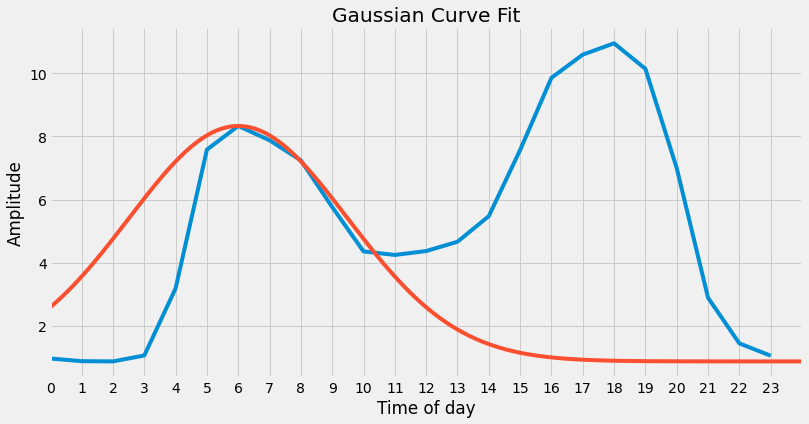

In [83]:
plotGaussFit(y2)

#### Create code that calculates the error

In [54]:
# y2 = gauss(x_all, H_offset,A1,mu1,sigma)

xgauss = gauss(df['0_x'].values[0]-2, H_offset,A1,mu1,initialSigma()) # Get the value of the gauss two points before the mean/peak
xprofile = df[str(df['0_x'].values[0]-2)].values[0] # Get the value of the profile two points before mean/peak
error = np.sqrt(xgauss - xprofile)**2 # Calculate the RMSE error between these points

#### Create loop that adjusts the std deviation until error is reduced satisfactorily

##### Error code for gauss1

In [397]:
# Code that finds the value one point above the range index
sigma1, i1 = initialSigma1()

xprofile1 = df[str(i1+1)].values[0] # Get the amplitude values one point above the min index

xgauss = gauss(int(i1+1), H_offset,A1,mu1,sigma1) # Get the value of the gauss one point above the min range amplitude

error1 = xgauss - xprofile1# Calculate the error between these points

tolerance1 = 0.1
i = 0.1 # Constant value by which to increase/decrease the range in the initial sigma function

while np.sqrt(error1**2) > tolerance1:
    previous_error1 = error1

    sigma1, i1 = initialSigma1(increment = i)
    xgauss = gauss(int(i1+1), H_offset,A1,mu1,sigma1) # Get the value of the gauss one point above the min peak
    error1 = xgauss - xprofile1# Calculate the error between these points

    # conditional for gauss 1
    if error1 > previous_error1:
        i = i + 0.1
        sigma1, i1 = initialSigma1(increment = i)
        xgauss = gauss(int(i1+1), H_offset,A1,mu1,sigma1) # Get the value of the gauss one point above the min peak
        error1 = xgauss - xprofile1# Calculate the error between these points
    else:
        i = i - 0.1
        sigma1, i1 = initialSigma1(increment = i)
        xgauss = gauss(int(i1+1), H_offset,A1,mu1,sigma1) # Get the value of the gauss one point above the min peak
        error1 = xgauss - xprofile1# Calculate the error between these points

sigma1 = np.sqrt(sigma1**2)
print("sigma4 = {}".format(sigma1))
print("error1 = xgauss - xprofile1 = {} - {} = {}".format(xgauss,xprofile1,error1))

sigma4 = 1.1594202898550763
error1 = xgauss - xprofile1 = 1.140148504732188 - 1.0649477412205948 = 0.07520076351159322


#### Error code for gauss 3

In [398]:
# Code that finds the value one point above the range index
sigma3, i3 = initialSigma3()

xprofile3 = df[str(i3+1)].values[0] # Get the amplitude values one point above the min index

xgauss = gauss(int(i3+1), H_offset,A2,mu2,sigma3) # Get the value of the gauss one point above the min range amplitude

error3 = xgauss - xprofile3# Calculate the error between these points

tolerance1 = 0.1
i = 0.1 # Constant value by which to increase/decrease the range in the initial sigma function

while np.sqrt(error3**2) > tolerance1:
    previous_error3 = error3

    sigma3, i3 = initialSigma3(increment = i)
    xgauss = gauss(int(i3+1), H_offset,A2,mu2,sigma3) # Get the value of the gauss one point above the min peak
    error3 = xgauss - xprofile3# Calculate the error between these points

    # conditional for gauss 1
    if error3 > previous_error3:
        i = i + 0.1
        sigma3, i3 = initialSigma3(increment = i)
        xgauss = gauss(int(i3+1), H_offset,A2,mu2,sigma3) # Get the value of the gauss one point above the min peak
        error3 = xgauss - xprofile3# Calculate the error between these points
    else:
        i = i - 0.1
        sigma3, i3 = initialSigma3(increment = i)
        xgauss = gauss(int(i3+1), H_offset,A2,mu2,sigma3) # Get the value of the gauss one point above the min peak
        error3 = xgauss - xprofile3# Calculate the error between these points

sigma3 = np.sqrt(sigma3**2)
print("sigma4 = {}".format(sigma3))
print("error1 = xgauss - xprofile3 = {} - {} = {}".format(xgauss,xprofile3,error3))

sigma4 = 4.11764705882353
error1 = xgauss - xprofile3 = 4.3617669388509155 - 4.372030016105545 = -0.010263077254629493


#### Error code for gauss2

In [400]:
sigma2, i2 = initialSigma2()

xprofile2 = df[str(i2-1)].values[0] # Get the amplitude values one point below the max index

xgauss = gauss(int(i2-1), H_offset,A1,mu1,sigma2) # Get the value of the gauss one point below the max index amplitude

error2 = xgauss - xprofile2# Calculate the error between these points

tolerance2 = 0.1
i = 0.5 # Constant value by which to increase/decrease the range in the initial sigma function
print(i2)
while np.sqrt(error2**2) > tolerance2:
    previous_error2 = error2
    print("error2 = xgauss - xprofile2 = {} - {} = {}".format(xgauss,xprofile2,error2))
    sigma2, i2 = initialSigma2(increment = i)
    xgauss = gauss(int(i2-1), H_offset,A1,mu1,sigma2) # Get the value of the gauss one point below the max index peak
    error2 = xgauss - xprofile2# Calculate the error between these points
    
    # Conditional for gauss2
    if error2 > previous_error2:
        i = i + 0.1
        sigma2, i2 = initialSigma2(increment = i)
        xgauss = gauss(int(i2-1), H_offset,A1,mu1,sigma2) # Get the value of the gauss one point below the max index peak
        error2 = xgauss - xprofile2# Calculate the error between these points
    else:
        i = i -0.1        
        sigma2, i2 = initialSigma2(increment = i)
        xgauss = gauss(int(i2-1), H_offset,A1,mu1,sigma2) # Get the value of the gauss one point below the max peak
        error2 = xgauss - xprofile2# Calculate the error between these points

sigma2 = np.sqrt(sigma2**2)
print("sigma4 = {}".format(sigma2))
print("error2 = xgauss - xprofile2 = {} - {} = {}".format(xgauss,xprofile2,error2))

11
error2 = xgauss - xprofile2 = 2.950499112090725 - 4.360818929809788 = -1.4103198177190635
error2 = xgauss - xprofile2 = 2.4620014896432307 - 4.360818929809788 = -1.8988174401665576
error2 = xgauss - xprofile2 = 2.5761756089594936 - 4.360818929809788 = -1.7846433208502948
error2 = xgauss - xprofile2 = 2.695668706772001 - 4.360818929809788 = -1.6651502230377875
error2 = xgauss - xprofile2 = 2.8204595401564987 - 4.360818929809788 = -1.5403593896532897
error2 = xgauss - xprofile2 = 2.950499112090725 - 4.360818929809788 = -1.4103198177190635
error2 = xgauss - xprofile2 = 3.0857090909036815 - 4.360818929809788 = -1.2751098389061069
error2 = xgauss - xprofile2 = 3.2259803648231458 - 4.360818929809788 = -1.1348385649866426
error2 = xgauss - xprofile2 = 3.371171754968854 - 4.360818929809788 = -0.9896471748409343
error2 = xgauss - xprofile2 = 3.5211089098514154 - 4.360818929809788 = -0.8397100199583729
error2 = xgauss - xprofile2 = 3.675583403827038 - 4.360818929809788 = -0.6852355259827503
e

#### Error code for gauss 4

In [401]:
sigma4, i4 = initialSigma4()

print(i4)

xprofile4 = df[str(i4-1)].values[0] # Get the amplitude values one point below the max index

xgauss = gauss(int(i4-1), H_offset,A2,mu2,sigma4) # Get the value of the gauss one point below the max index amplitude

error4 = xgauss - xprofile4# Calculate the error between these points

tolerance2 = 0.1
i = 0.1 # Constant value by which to increase/decrease the range in the initial sigma function

while np.sqrt(error4**2) > tolerance2:
    previous_error4 = error4

    sigma4, i4 = initialSigma4(increment = i)
    xgauss = gauss(int(i4-1), H_offset,A2,mu2,sigma4) # Get the value of the gauss one point below the max index peak
    error4 = xgauss - xprofile4# Calculate the error between these points
    
    # Conditional for gauss2
    if error4 > previous_error4:
        i = i + 0.1
        sigma4, i4 = initialSigma4(increment = i)
        xgauss = gauss(int(i4-1), H_offset,A2,mu2,sigma4) # Get the value of the gauss one point below the max index peak
        error4 = xgauss - xprofile4# Calculate the error between these points
    else:
        i = i - 0.1        
        sigma4, i4 = initialSigma4(increment = i)
        xgauss = gauss(int(i4-1), H_offset,A2,mu2,sigma4) # Get the value of the gauss one point below the max peak
        error4 = xgauss - xprofile4# Calculate the error between these points

sigma4 = np.sqrt(sigma4**2)
print("sigma4 = {}".format(sigma4))
print("error2 = xgauss - xprofile2 = {} - {} = {}".format(xgauss,xprofile4,error4))

23
sigma4 = 1.6949152542372936
error2 = xgauss - xprofile2 = 1.499846761059263 - 1.4480695617085948 = 0.05177719935066816


### Code that creates plots

In [402]:
# sigma1, sigma3, i1, i3= initialSigma1()
# sigma2, sigma4, i2, i4 = initialSigma2()
x_all = np.arange(0, 24)
y1 = gauss(x_all, H_offset,A1,mu1,sigma1)
y2 = gauss(x_all, H_offset,A1,mu1,sigma2)
y3 = gauss(x_all, H_offset,A2,mu2,sigma3)
y4 = gauss(x_all, H_offset,A2,mu2,sigma4)

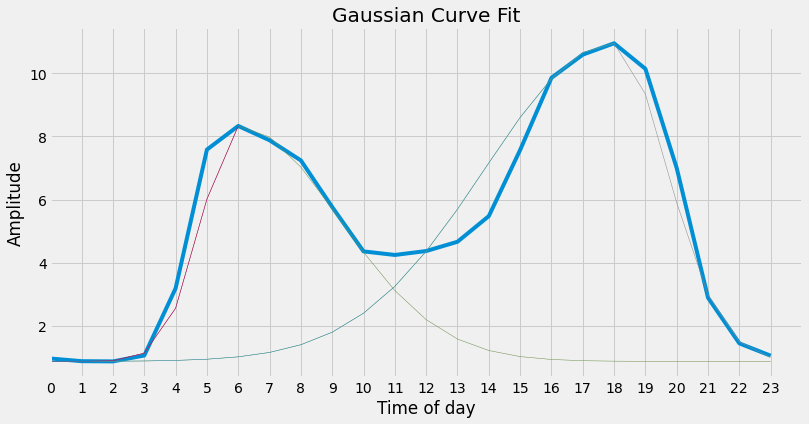

In [403]:
# Household ids
# id = [2230]#,1002790,483,3063,5351,12020322,5283,5293,168,7118,156,5239,29,1418,1005536]

x_all = np.arange(0, 24, 1) # entire range of x, both in and out of spec

# build the plot
fig, ax = plt.subplots(figsize=(12,6))
plt.style.use('fivethirtyeight')  

# Plot the households loadprofile
fig = plt.plot(describe_household().iloc[0,0:24])
plt.title("Household "+str(i))

# Plot Gaussian fit
# ax.plot(x_all[:len(x_all)//4],y2[:len(y2)//4], linewidth = 0.8)

for i in np.arange(1,4):

    if i % 2 == 0:
        # Plot Gaussian fit
        ax.plot(x_all[6:],y2[6:],linewidth = 0.5)
        ax.plot(x_all[18:],y4[18:],linewidth = 0.5)
    else:
        ax.plot(x_all[:7],y1[:7],linewidth = 0.5)
        ax.plot(x_all[:19],y3[:19],linewidth = 0.5)


# Set the labels and axis limits
ax.set_xlim([0,24])
ax.set_xlabel('Time of day')
ax.set_ylabel("Amplitude")
ax.set_title('Gaussian Curve Fit')

# # Save the figure
# plt.savefig('normal_curve.png', dpi=72, bbox_inches='tight')
plt.show()

### Create code that plots the sigma changes

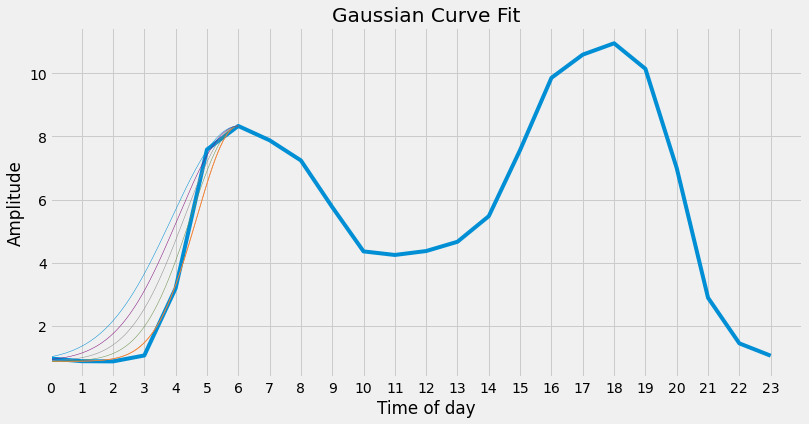

In [53]:
y2 = gauss(x_all, H_offset,A1,mu1,initialSigma())
# Household ids
# id = [2230]#,1002790,483,3063,5351,12020322,5283,5293,168,7118,156,5239,29,1418,1005536]

x_all = np.arange(0, 24, 0.001) # entire range of x, both in and out of spec

# build the plot
fig, ax = plt.subplots(figsize=(12,6))
plt.style.use('fivethirtyeight')  

# Plot the households loadprofile
fig = plt.plot(describe_household().iloc[0,0:24])
plt.title("Household "+str(i))

# Plot Gaussian fit
ax.plot(x_all[:len(x_all)//4],y2[:len(y2)//4], linewidth = 0.8)

for i in np.arange(0,1,0.2):
    y2 = gauss(x_all, H_offset,A1,mu1,initialSigma()+i)
    # Plot Gaussian fit
    ax.plot(x_all[:len(x_all)//4],y2[:len(y2)//4],linewidth = 0.5)

# Set the labels and axis limits
ax.set_xlim([0,24])
ax.set_xlabel('Time of day')
ax.set_ylabel("Amplitude")
ax.set_title('Gaussian Curve Fit')

# # Save the figure
# plt.savefig('normal_curve.png', dpi=72, bbox_inches='tight')
plt.show()

In [222]:
df.values.T

array([[ 0.96963948],
       [ 0.88488065],
       [ 0.87799364],
       [ 1.06494774],
       [ 3.19145904],
       [ 7.58371893],
       [ 8.33204914],
       [ 7.87926694],
       [ 7.24088453],
       [ 5.76545539],
       [ 4.36081893],
       [ 4.24792553],
       [ 4.37203002],
       [ 4.66599859],
       [ 5.47735664],
       [ 7.57151307],
       [ 9.85606039],
       [10.59032874],
       [10.94988631],
       [10.14131568],
       [ 6.99757768],
       [ 2.89250036],
       [ 1.44806956],
       [ 1.0580505 ],
       [ 6.        ],
       [18.        ]])